In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [414]:
df = pd.read_csv('../data/day_ahead_energy_prices.csv', delimiter=",")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [415]:
SPLIT_DATE = df.index[int(0.2 * len(df))]


train = df.loc[df.index < SPLIT_DATE]
test = df.loc[df.index >= SPLIT_DATE]

train.shape, test.shape

((67104, 1), (16777, 1))

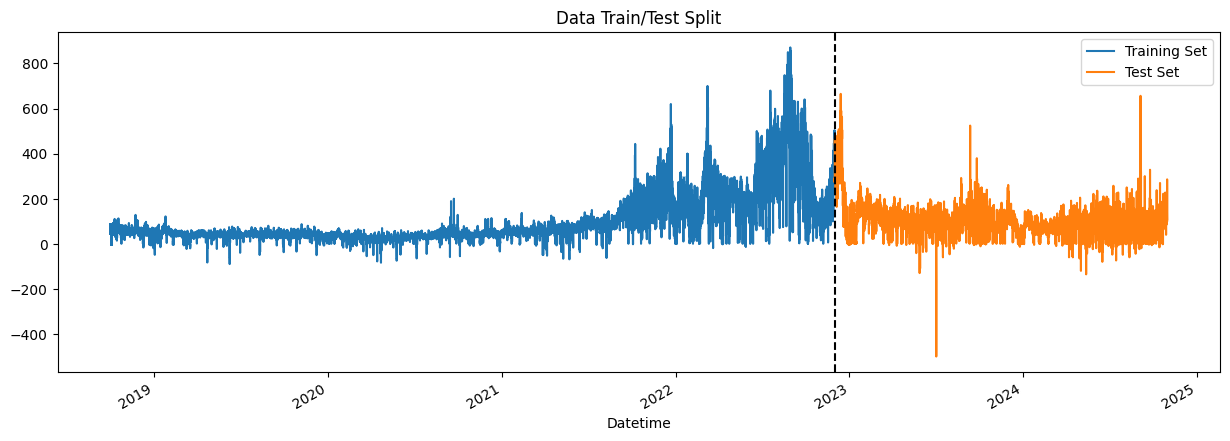

In [416]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(SPLIT_DATE, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [417]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear
Datetime,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44
2024-10-29 21:00:00+00:00,118.08,21,1,303,44
2024-10-29 20:00:00+00:00,124.05,20,1,303,44
2024-10-29 19:00:00+00:00,140.60,19,1,303,44
2024-10-29 18:00:00+00:00,203.82,18,1,303,44
...,...,...,...,...,...
2018-10-01 02:00:00+00:00,47.59,2,0,274,40
2018-10-01 01:00:00+00:00,47.38,1,0,274,40
2018-10-01 00:00:00+00:00,51.41,0,0,274,40


In [418]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofyear', 'dayofweek']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=25)

[0]	validation_0-rmse:112.04032	validation_1-rmse:112.01346
[25]	validation_0-rmse:100.32162	validation_1-rmse:96.07275
[50]	validation_0-rmse:92.48453	validation_1-rmse:85.36988
[75]	validation_0-rmse:87.32269	validation_1-rmse:78.40900
[100]	validation_0-rmse:83.98520	validation_1-rmse:74.27224


/Users/boh/Library/Mobile Documents/com~apple~CloudDocs/uni/tu/Fächer/LSDI-Project/LSDI-Project-/pj-env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[125]	validation_0-rmse:81.81254	validation_1-rmse:71.58886
[150]	validation_0-rmse:80.41798	validation_1-rmse:69.76149
[175]	validation_0-rmse:79.49706	validation_1-rmse:68.58675
[200]	validation_0-rmse:78.87012	validation_1-rmse:67.78840
[225]	validation_0-rmse:78.39721	validation_1-rmse:67.20635
[250]	validation_0-rmse:78.07555	validation_1-rmse:66.80576
[275]	validation_0-rmse:77.83696	validation_1-rmse:66.49191
[300]	validation_0-rmse:77.64713	validation_1-rmse:66.24026
[325]	validation_0-rmse:77.49448	validation_1-rmse:66.06068
[350]	validation_0-rmse:77.37649	validation_1-rmse:65.87847
[375]	validation_0-rmse:77.29048	validation_1-rmse:65.73525
[400]	validation_0-rmse:77.20864	validation_1-rmse:65.58929
[425]	validation_0-rmse:77.12575	validation_1-rmse:65.48570
[450]	validation_0-rmse:77.03806	validation_1-rmse:65.44476
[475]	validation_0-rmse:76.95174	validation_1-rmse:65.48308
[495]	validation_0-rmse:76.87704	validation_1-rmse:65.47043


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

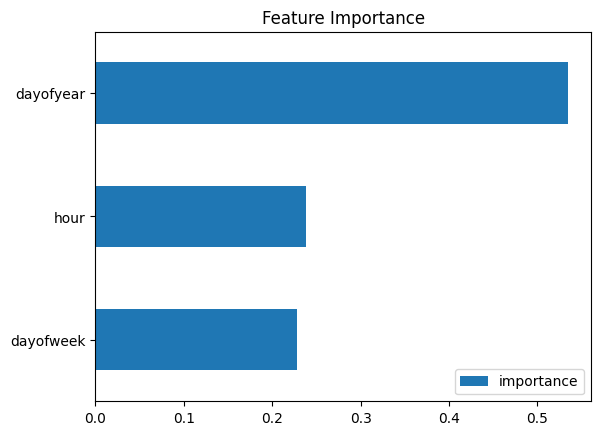

In [419]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [420]:
test['prediction'] = reg.predict(X_test)
test

,Price,hour,dayofweek,dayofyear,weekofyear,prediction
Datetime,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,71.755028
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,78.869308
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,90.688858
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,96.010544
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,101.203667
...,...,...,...,...,...,...
2022-12-01 02:00:00+00:00,274.80,2,3,335,48,72.788925
2022-12-01 01:00:00+00:00,284.76,1,3,335,48,72.788925
2022-12-01 00:00:00+00:00,291.43,0,3,335,48,72.788925


In [421]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

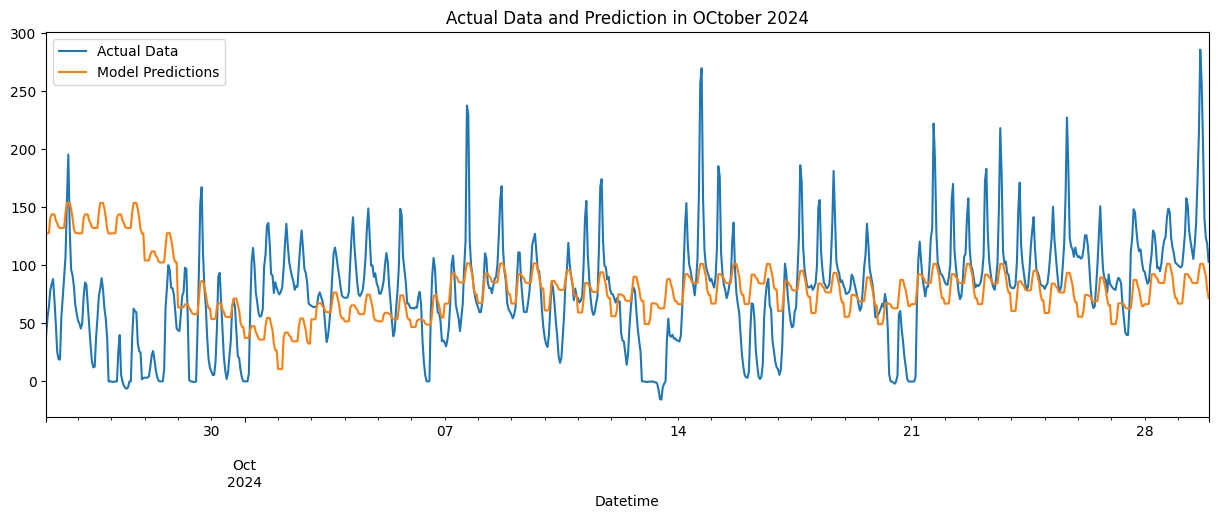

In [422]:
WINDOW = df.iloc[:int(0.01 * (len(df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-')
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
plt.legend(['Actual Data', 'Model Predictions'])
ax.set_title('Actual Data and Prediction in OCtober 2024')
plt.show()

In [423]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 65.44


In [424]:
#days and (absolute) error realtion
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean()

date
2022-11-30    185.225133
2022-12-01    298.655329
2022-12-02    246.345930
2022-12-03    198.337358
2022-12-04    188.048841
                 ...    
2024-10-25     38.007688
2024-10-26     29.278970
2024-10-27     30.687175
2024-10-28     26.871195
2024-10-29     57.553221
Name: error, Length: 700, dtype: float64